In [1]:
# Step 1: Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os

# Printing the List of contents of FraudShield folder from Google Drive
path = "/content/drive/MyDrive/MLPersonalProjects/FraudShield"
if os.path.exists(path):
    print("Google Drive connected successfully!")
    print("Contents of FraudShield folder:")
    print(os.listdir(path))
else:
    print("❌ Path not found. Please check folder name or spelling.")


Google Drive connected successfully!
Contents of FraudShield folder:
['creditcard.csv', 'Fraud_Shield_project.ipynb']


In [3]:
# Step 2: Load dataset from Google Drive
import pandas as pd

file_path = '/content/drive/MyDrive/MLPersonalProjects/FraudShield/creditcard.csv'
df = pd.read_csv(file_path)

# Preview
df.head()


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


Class
0    284315
1       492
Name: count, dtype: int64


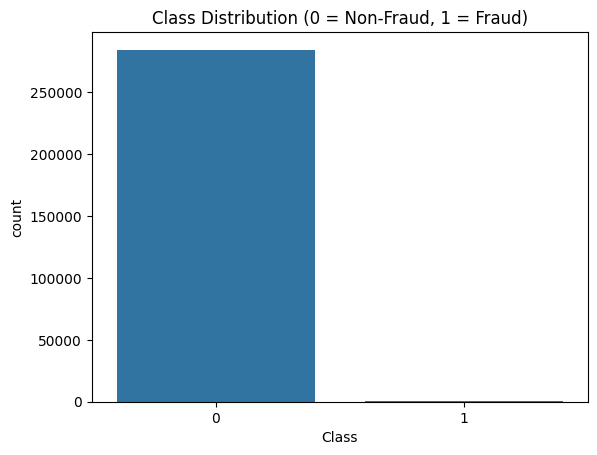

In [4]:
# Step 3: EDA - Understand Class Distribution
import seaborn as sns
import matplotlib.pyplot as plt

print(df['Class'].value_counts())

sns.countplot(x='Class', data=df)
plt.title('Class Distribution (0 = Non-Fraud, 1 = Fraud)')
plt.show()


In [5]:
# Step 4: Preprocessing & Train-Test Split
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X = df.drop('Class', axis=1)
y = df['Class']

# Normalize 'Amount'
X['Amount'] = StandardScaler().fit_transform(X['Amount'].values.reshape(-1, 1))

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)


In [6]:
# Step 5: Handle Class Imbalance using SMOTE
!pip install -q imbalanced-learn
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

print(f"Original: {y_train.value_counts()}")
print(f"Resampled: {pd.Series(y_train_res).value_counts()}")

Original: Class
0    227451
1       394
Name: count, dtype: int64
Resampled: Class
0    227451
1    227451
Name: count, dtype: int64


In [7]:
# Step 6: Train XGBoost Model
!pip install -q xgboost
from xgboost import XGBClassifier

model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
model.fit(X_train_res, y_train_res)


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [18:51:47] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)

In [8]:
# Step 7: Evaluate Model
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
y_pred = model.predict(X_test)
# Confusion Matrix
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
# Classification Report (Precision, Recall, F1-score)
print("\nClassification Report:\n", classification_report(y_test, y_pred))
# ROC-AUC Score
print("ROC-AUC Score:", roc_auc_score(y_test, model.predict_proba(X_test)[:,1]))

Confusion Matrix:
 [[56839    25]
 [   13    85]]

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.77      0.87      0.82        98

    accuracy                           1.00     56962
   macro avg       0.89      0.93      0.91     56962
weighted avg       1.00      1.00      1.00     56962

ROC-AUC Score: 0.9788973763393934


In [9]:
# Step 8: Save the Model to Google Drive
import pickle

model_path = '/content/drive/MyDrive/MLPersonalProjects/FraudShield/fraud_detection_model.pkl'
with open(model_path, 'wb') as f:
    pickle.dump(model, f)
print("Model saved to:", model_path)

Model saved to: /content/drive/MyDrive/MLPersonalProjects/FraudShield/fraud_detection_model.pkl
